#  Handwritten Equation Sum Classifier (From Scratch)
This notebook builds a deep neural network from scratch using NumPy to classify the **sum of two handwritten digits**.
We use a synthetic dataset made by combining MNIST digit pairs and training a model to predict their sum (0–18).

##  Step 1: Load and Prepare the Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load the MNIST dataset (28x28 grayscale images of digits 0–9)
mnist = fetch_openml('mnist_784', version=1)

# Normalize the pixel values to [0, 1] and convert labels to integers
X_raw = mnist.data.to_numpy().astype(np.float32) / 255.0
y_raw = mnist.target.to_numpy().astype(int)

# Limit dataset to the first 60,000 samples (standard training split)
X_raw = X_raw[:60000]
y_raw = y_raw[:60000]

# Prepare a new dataset of 30,000 images created by horizontally stacking two digits
X_data, y_data = [], []
for _ in range(30000):
    # Randomly select two images from the first 2,000 samples
    i1, i2 = np.random.randint(0, 2000, size=2)
    
    # Reshape the flattened 784-pixel images to 28x28
    img1 = X_raw[i1].reshape(28, 28)
    img2 = X_raw[i2].reshape(28, 28)
    
    # Combine them side by side (resulting in a 28x56 image)
    combined = np.hstack([img1, img2])  
    
    # Flatten the combined image back to a 1D vector and store it
    X_data.append(combined.flatten())
    
    # Label is the sum of the two digits (range: 0+0 to 9+9 → 0 to 18)
    y_data.append(y_raw[i1] + y_raw[i2])

# Convert to NumPy arrays
X_data = np.array(X_data)
y_data = np.array(y_data)

# One-hot encode the labels (19 classes: 0 through 18)
y_onehot = np.zeros((len(y_data), 19))
for i, val in enumerate(y_data):
    y_onehot[i, val] = 1  # Set the appropriate index to 1

# Split the dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_onehot, test_size=0.2, random_state=42)


##  Step 2: Visualize Some Samples

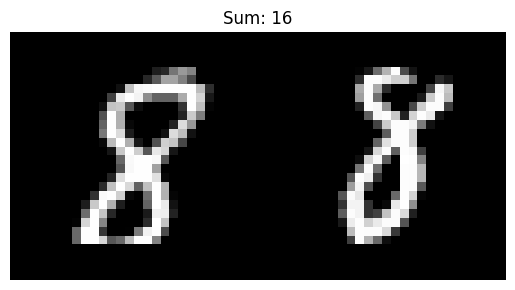

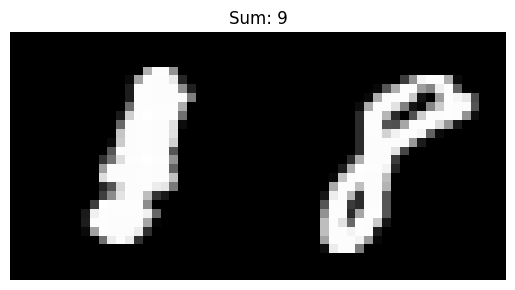

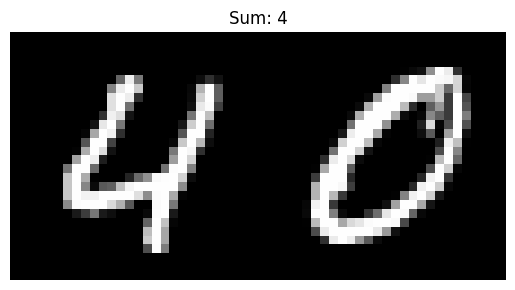

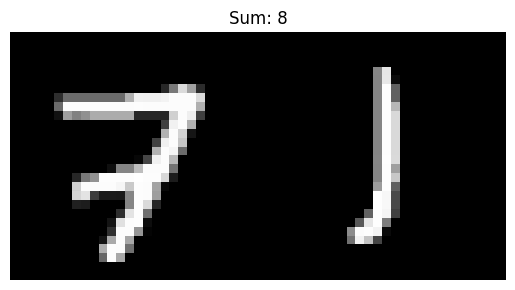

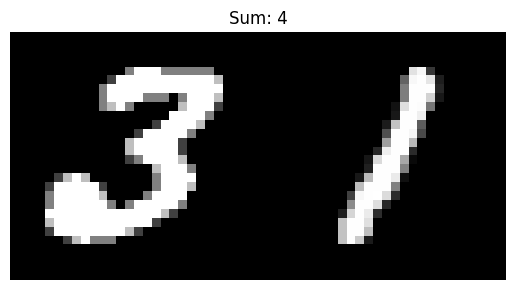

In [ ]:
# Display the first 5 combined digit images and their labels
for i in range(5):
    # Reshape the flattened vector back to a 28x56 image (two digits side by side)
    img = X_data[i].reshape(28, 56)
    
    # Retrieve the label, which is the sum of the two digits in the image
    label = y_data[i]
    
    # Display the image using grayscale colormap
    plt.imshow(img, cmap='gray')
    
    # Set the title of the plot to show the sum of the two digits
    plt.title(f"Sum: {label}")
    
    # Remove axis ticks and labels for a cleaner look
    plt.axis('off')
    
    # Show the plot
    plt.show()


##  Step 3: Helper Functions

In [ ]:
def relu(Z):
    """
    ReLU activation function.

    Parameters:
    Z (np.ndarray): Input array (pre-activation values).

    Returns:
    np.ndarray: Output array where all negative values are set to 0, positive remain unchanged.
    """
    return np.maximum(0, Z)

def relu_derivative(Z):
    """
    Derivative of the ReLU function.

    Parameters:
    Z (np.ndarray): Input array (pre-activation values from forward pass).

    Returns:
    np.ndarray: Array of 0s and 1s. 1 where Z > 0, else 0.
    """
    return (Z > 0).astype(float)

def softmax(Z):
    """
    Softmax activation function for multi-class classification.

    Parameters:
    Z (np.ndarray): Input 2D array (shape: classes x examples), raw scores (logits).

    Returns:
    np.ndarray: Probabilities for each class, normalized across classes for each example.
    """
    exp_z = np.exp(Z - np.max(Z, axis=0, keepdims=True))  # Stability trick
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

def cross_entropy(y_hat, y_true):
    """
    Cross-entropy loss for one-hot encoded labels.

    Parameters:
    y_hat (np.ndarray): Predicted probabilities (output of softmax), shape: (classes x examples).
    y_true (np.ndarray): True one-hot encoded labels, same shape as y_hat.

    Returns:
    float: Cross-entropy loss (averaged over all examples).
    """
    return -np.mean(np.sum(y_true * np.log(y_hat + 1e-8), axis=0))


##  Step 4: Model Functions

In [ ]:
def initialize_parameters(layer_dims):
    """
    Initializes weights and biases for each layer in the neural network.

    Parameters:
    layer_dims (list): List of integers representing the number of units in each layer.
                       For example, [input_dim, hidden1, hidden2, ..., output_dim]

    Returns:
    dict: A dictionary containing initialized weights and biases:
          - "W1", "b1", ..., "WL", "bL"
          Weights are initialized using He initialization.
    """
    parameters = {}  # Dictionary to store all parameters
    for l in range(1, len(layer_dims)):
        # He initialization for weights: good for ReLU activation
        parameters[f"W{l}"] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2. / layer_dims[l-1])
        # Initialize biases to zeros
        parameters[f"b{l}"] = np.zeros((layer_dims[l], 1))
    return parameters


def forward_prop(X, Y, parameters):
    """
    Performs forward propagation through the network.

    Parameters:
    X (np.ndarray): Input data of shape (input_dim, number_of_examples).
    Y (np.ndarray): True one-hot encoded labels of shape (num_classes, number_of_examples).
    parameters (dict): Dictionary containing weights and biases for each layer.

    Returns:
    AL (np.ndarray): Final output (softmax probabilities), shape (num_classes, number_of_examples).
    loss (float): Cross-entropy loss.
    caches (list): List of cached values for each layer used in backpropagation.
    """
    caches = []         # List to store intermediate results for backpropagation
    A = X               # Initial activation is the input
    L = len(parameters) // 2  # Number of layers (excluding input)

    # Forward propagation through hidden layers
    for l in range(1, L):
        W, b = parameters[f"W{l}"], parameters[f"b{l}"]   # Get current layer weights and biases
        Z = W @ A + b                                     # Linear forward step
        A_prev = A                                        # Store previous activation for cache
        A = relu(Z)                                       # Apply ReLU activation
        caches.append((A_prev, Z, W, b))                  # Save cache for backprop

    # Forward propagation through output layer
    W, b = parameters[f"W{L}"], parameters[f"b{L}"]       # Final layer weights and biases
    ZL = W @ A + b                                        # Linear step for output layer
    AL = softmax(ZL)                                      # Apply softmax activation
    caches.append((A, ZL, W, b))                          # Save final cache

    loss = cross_entropy(AL, Y)                           # Compute cross-entropy loss
    return AL, loss, caches


def backward_prop(AL, Y, caches):
    """
    Performs backward propagation to compute gradients.

    Parameters:
    AL (np.ndarray): Predicted output probabilities from forward pass (shape: classes x examples).
    Y (np.ndarray): True one-hot encoded labels (same shape as AL).
    caches (list): Cached values from forward propagation.

    Returns:
    grads (dict): Gradients of weights and biases:
                  - "dW1", "db1", ..., "dWL", "dbL"
    """
    grads = {}              # Dictionary to store gradients
    m = Y.shape[1]          # Number of examples
    L = len(caches)         # Number of layers

    # Gradient of the loss w.r.t. softmax input (ZL)
    A_prev, ZL, WL, bL = caches[-1]
    dZL = AL - Y                                      # Derivative of softmax-crossentropy combo
    grads[f"dW{L}"] = (1/m) * dZL @ A_prev.T          # Gradient of weights
    grads[f"db{L}"] = (1/m) * np.sum(dZL, axis=1, keepdims=True)  # Gradient of biases
    dA_prev = WL.T @ dZL                              # Backpropagate to previous activation

    # Backprop through hidden layers
    for l in reversed(range(1, L)):
        A_prev, Z, W, b = caches[l-1]                 # Get cache values
        dZ = dA_prev * relu_derivative(Z)             # Derivative through ReLU
        grads[f"dW{l}"] = (1/m) * dZ @ A_prev.T        # Weight gradients
        grads[f"db{l}"] = (1/m) * np.sum(dZ, axis=1, keepdims=True)  # Bias gradients
        dA_prev = W.T @ dZ                             # Backpropagate to next layer

    return grads


def update_parameters(parameters, grads, learning_rate):
    """
    Updates the network parameters using gradient descent.

    Parameters:
    parameters (dict): Current weights and biases.
    grads (dict): Gradients of weights and biases from backward propagation.
    learning_rate (float): Learning rate for gradient descent.

    Returns:
    dict: Updated parameters.
    """
    L = len(parameters) // 2  # Number of layers
    for l in range(1, L + 1):
        # Update weights and biases using gradient descent
        parameters[f"W{l}"] -= learning_rate * grads[f"dW{l}"]
        parameters[f"b{l}"] -= learning_rate * grads[f"db{l}"]
    return parameters


##  Step 5: Train the Model

In [ ]:
def train_model(X, Y, layer_dims, learning_rate=0.1, iterations=2001, print_every=500):
    """
    Trains a deep neural network using forward and backward propagation.

    Parameters:
    X (np.ndarray): Input data, shape (input_dim, number_of_examples).
    Y (np.ndarray): One-hot encoded labels, shape (num_classes, number_of_examples).
    layer_dims (list): List defining the number of neurons in each layer.
                       Example: [input_dim, hidden1, hidden2, ..., output_dim]
    learning_rate (float): Step size for updating parameters during gradient descent.
    iterations (int): Number of training iterations (epochs).
    print_every (int): Interval for printing the loss during training.

    Returns:
    parameters (dict): Trained weights and biases.
    losses (list): List of loss values over iterations (for plotting or analysis).
    """
    # Initialize weights and biases for all layers
    parameters = initialize_parameters(layer_dims)
    losses = []  # To store loss after each iteration

    # Training loop
    for i in range(iterations):
        # Forward pass: compute predictions and loss
        AL, loss, caches = forward_prop(X, Y, parameters)

        # Backward pass: compute gradients
        grads = backward_prop(AL, Y, caches)

        # Update parameters using gradient descent
        parameters = update_parameters(parameters, grads, learning_rate)

        # Record the loss for later analysis
        losses.append(loss)

        # Optionally print the loss at set intervals
        if i % print_every == 0:
            print(f"Iteration {i}: Loss = {loss:.4f}")

    return parameters, losses


In [ ]:
# Transpose training data so that shape becomes (features, number_of_examples)
# This matches the expected input shape for our neural network implementation
X_train_T = X_train.T
y_train_T = y_train.T

# Define the architecture of the neural network
# 1568 input neurons (28x56 images flattened)
# 4 hidden layers: 512 → 256 → 128 → 64
# 19 output neurons (summing digits: 0 to 18)
layer_dims = [1568, 512, 256, 128, 64, 19]

# Train the model using the train_model function
# params will contain the trained weights and biases
# loss_history will contain the loss value at each iteration
params, loss_history = train_model(X_train_T, y_train_T, layer_dims)


Iteration 0: Loss = 3.0352
Iteration 500: Loss = 0.8191
Iteration 1000: Loss = 0.1094
Iteration 1500: Loss = 0.0245
Iteration 2000: Loss = 0.0103


##  Step 6: Predict and Evaluate

In [ ]:
def predict(X, parameters):
    """
    Performs forward propagation and returns predicted class labels.

    Parameters:
    X (np.ndarray): Input data, shape (input_dim, number_of_examples).
    parameters (dict): Trained weights and biases.

    Returns:
    np.ndarray: Predicted class labels (shape: number_of_examples,).
    """
    A = X
    L = len(parameters) // 2  # Number of layers

    # Forward pass through hidden layers with ReLU
    for l in range(1, L):
        W, b = parameters[f"W{l}"], parameters[f"b{l}"]
        Z = W @ A + b
        A = relu(Z)

    # Output layer (softmax)
    W, b = parameters[f"W{L}"], parameters[f"b{L}"]
    ZL = W @ A + b
    probs = softmax(ZL)

    # Return the index of the highest probability for each example
    return np.argmax(probs, axis=0)


# Transpose test data for compatibility: shape = (features, examples)
preds = predict(X_test.T, params)

# Convert one-hot encoded test labels to class indices
true_labels = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = np.mean(preds == true_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 87.85%


## ✅ Conclusion
This notebook demonstrated how to:
- Build a deep neural network from scratch
- Train it to recognize the **sum of two digits**
- Evaluate performance with NumPy only

